In [28]:
!pip install plotly
!pip install cufflinks

  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68734 sha256=cdfe3b82fb5ab7c7f27511a5ce332f10426d19587366aeace799259804fa6db7
  Stored in directory: c:\users\praga\appdata\local\pip\cache\wheels\29\b4\f8\2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
Successfully built cufflinks


In [29]:
import cv2
import math
import os, ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt # plotting
import matplotlib.patches as patches

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [10]:
dataset_path = r'C:\Users\praga\Downloads\global-wheat-detection'
dataset_img_train=r'C:\Users\praga\Downloads\global-wheat-detection\train'
dataset_img_test=r'C:\Users\praga\Downloads\global-wheat-detection\test'

In [12]:
train_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [13]:
sample_sub_df.head()

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50

In [14]:
print(f'Shape of training data: {train_df.shape}')
print(f'Shape of given test data: {sample_sub_df.shape}')

Shape of training data: (147793, 5)
Shape of given test data: (10, 2)


In [31]:
%%time
SAMPLE_LEN=2000
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(dataset_img_train + file_path)
   # return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_df["image_id"][:SAMPLE_LEN].progress_apply(load_image)

100%|██████████| 2000/2000 [00:00<00:00, 13735.36it/s]

Wall time: 153 ms


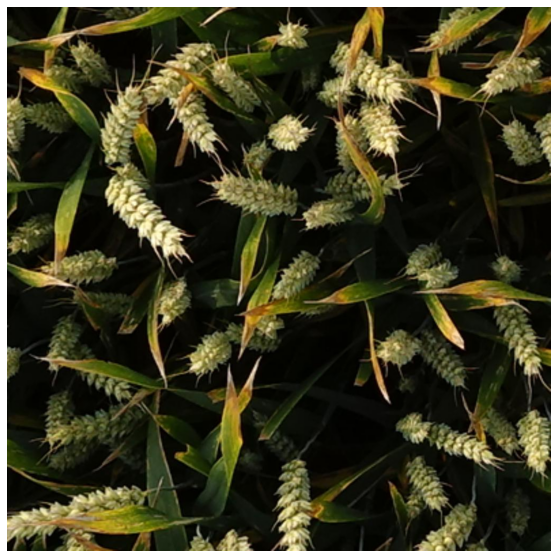

In [33]:
image = cv2.imread(r"C:\Users\praga\Downloads\global-wheat-detection\train\0dc9eb168.jpg")
height, width = image.shape[:2]
resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
print(f'Total no. of images                        : {train_df.shape[0]}')
print(f'Total no. of unique images                 : {train_df["image_id"].nunique()}')
print(f'Checking Dimentions - heights and widths   : {train_df["width"].unique()}, {train_df["height"].unique()}')
print(f'Maximum number of wheat heads in the Image : {max(train_df["image_id"].value_counts())}')
print(f'Average wheat heads in the Image           : {len(train_df)/train_df["image_id"].nunique()}')

Total no. of images                        : 147793
Total no. of unique images                 : 3373
Checking Dimentions - heights and widths   : [1024], [1024]
Maximum number of wheat heads in the Image : 116
Average wheat heads in the Image           : 43.8164838422769


C:\Users\praga\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


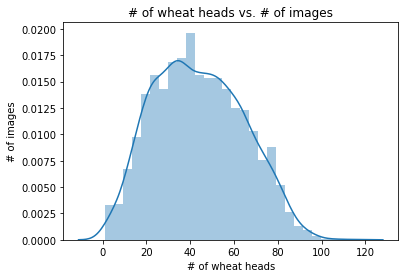

In [35]:
sns.distplot(train_df['image_id'].value_counts(), kde=True)
plt.xlabel('# of wheat heads')
plt.ylabel('# of images')
plt.title('# of wheat heads vs. # of images')
plt.show()

In [36]:
box_count = train_df["image_id"].value_counts()

hist_data = [box_count.values]
group_labels = ['Count'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=2)
fig.update_layout(title_text="Number of bounding boxes per image", template="simple_white", title_x=0.5)
fig.show()

In [37]:
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df

image_id                         bbox     source  x_min  y_min  \
0       b6ab77fd7   [834.0, 222.0, 56.0, 36.0]    usask_1  834.0  222.0   
1       b6ab77fd7  [226.0, 548.0, 130.0, 58.0]    usask_1  226.0  548.0   
2       b6ab77fd7  [377.0, 504.0, 74.0, 160.0]    usask_1  377.0  504.0   
3       b6ab77fd7  [834.0, 95.0, 109.0, 107.0]    usask_1  834.0   95.0   
4       b6ab77fd7  [26.0, 144.0, 124.0, 117.0]    usask_1   26.0  144.0   
...           ...                          ...        ...    ...    ...   
147788  5e0747034    [64.0, 619.0, 84.0, 95.0]  arvalis_2   64.0  619.0   
147789  5e0747034  [292.0, 549.0, 107.0, 82.0]  arvalis_2  292.0  549.0   
147790  5e0747034  [134.0, 228.0, 141.0, 71.0]  arvalis_2  134.0  228.0   
147791  5e0747034   [430.0, 13.0, 184.0, 79.0]  arvalis_2  430.0   13.0   
147792  5e0747034   [875.0, 740.0, 94.0, 61.0]  arvalis_2  875.0  740.0   

        width  height  
0        56.0    36.0  
1       130.0    58.0  
2        74.0   160.0  
3       109.0   107.0  
4       124.0   117.0  
...       ...     ...  
147788   84.0    95.0  
147789  107.0    82.0  
147790  141.0    71.0  
147791  184.0    79.0  
147792   94.0    61.0  

[147793 rows x 7 columns]

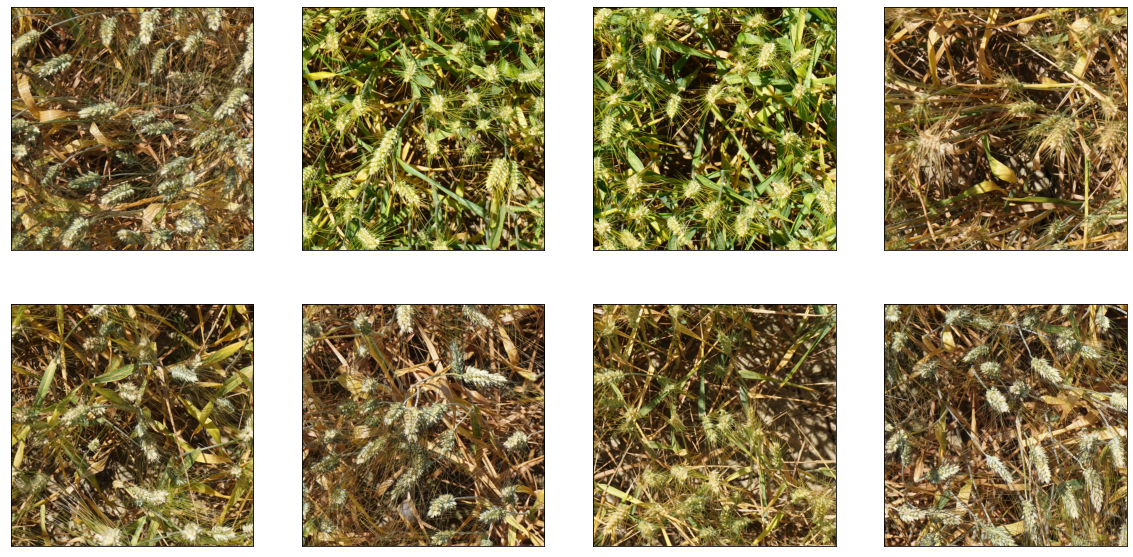

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=1000
for row in ax:
    for col in row:
        img = plt.imread(f'{os.path.join(dataset_path, "train", train_df["image_id"].unique()[count])}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count += 1
plt.show()

In [39]:
def get_bbox(image_id, df, col, color='white'):
    bboxes = df[df['image_id'] == image_id]
    
    for i in range(len(bboxes)):
        rect = patches.Rectangle(
            (bboxes['x_min'].iloc[i], bboxes['y_min'].iloc[i]),
            bboxes['width'].iloc[i], 
            bboxes['height'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')
        col.add_patch(rect)

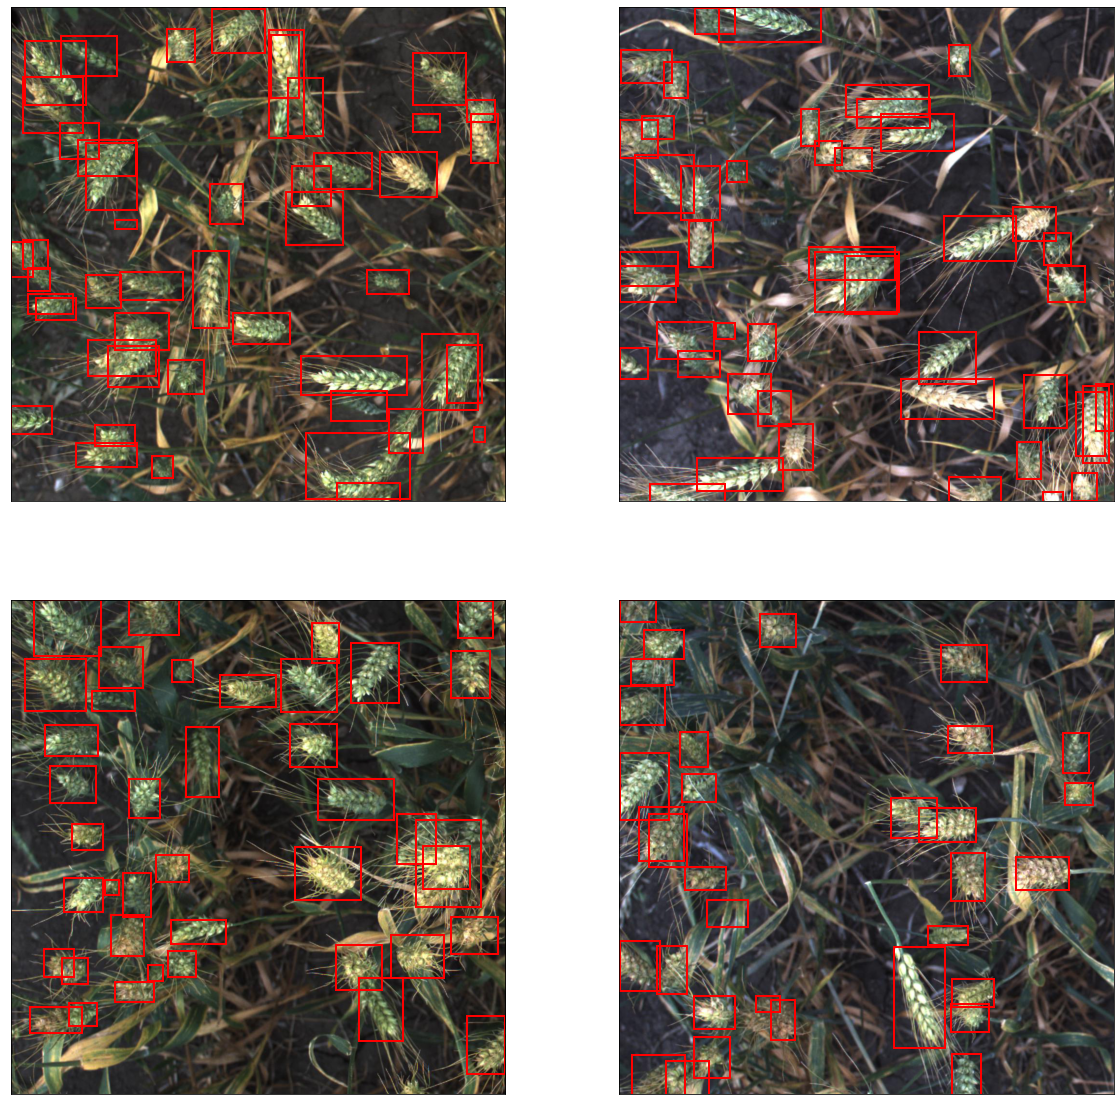

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
count=0
for row in ax:
    for col in row:
        img_id = train_df["image_id"].unique()[count]
        img = plt.imread(f'{os.path.join(dataset_path, "train", img_id)}.jpg')
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox(img_id, train_df, col, color='red')
        col.imshow(img)
        count += 1
plt.show()